In [11]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (12,8)})
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
resPH, stimPH = read_lmc('PHOTO')
res1, stim3 = read_lmc('LMC-BG1')
res2, stim3 = read_lmc('LMC-BG2')
res3, stim3 = read_lmc('LMC-BG3')
res4, stim4 = read_lmc('LMC-BG4')
res5, stim5 = read_lmc('LMC-BG5')
res6, stim6 = read_lmc('LMC-BG6')

TIME = 1.0
all_results = []

In [13]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [14]:
def convert_dtms_windowms_to_factor_dim(dt, window, TIME=1.0, LEN=10000):
    orignal_dt_ms = TIME/LEN * 1000
    factor = int(dt/orignal_dt_ms)
    dim = int(window / dt)
    return factor, dim


In [15]:

def test_run(beta=0, dt_ms=1.0, lag_ms=50, method='eig', top_i=1, dataset='', window_factor=2.0):

    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
    X_series, Y_series = get_data(dataset, factor)

    time = np.linspace(0, 1, len(X_series))

    if method == 'eig':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        lam = beta * np.eye(dim)

        X0Xp = X0 @ Xp.T
        X0X0 = X0 @ X0.T
        # solve eigenvalue problem
        w, vl = scipy.linalg.eig(X0Xp, (X0X0+lam))

        sortorder = np.argsort(w)
        thetas = vl[:, sortorder][:, ::-1]
        # theta = thetas[:, -2]
        w = w[sortorder][::-1]

        thetas[:, :top_i] *= thetas[:, :top_i][-1]
        theta = np.mean(thetas[:, :top_i], axis=-1)

        P_series = theta.real @ Xhan

    elif method == 'eig-comp':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        Xp = Xp[-1]
        lam = beta * np.eye(dim)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        A = np.eye(dim, k=1)
        A[-1] = a
        w, vl = scipy.linalg.eig(A, left=True, right=False)

        sortorder = np.argsort(w)
        thetas = vl[:, sortorder][:, ::-1]
        # theta = thetas[:, -2]
        w = w[sortorder][::-1]

        thetas[:, :top_i] *= thetas[:, :top_i][-1]
        theta = np.mean(thetas[:, :top_i] * w[:top_i], axis=-1)

        P_series = theta.real @ Xhan

    elif method == 'eig-C':
        P_series, theta, A, c = eig_companion_Cshift(X_series, dim, beta=beta)

    elif method == 'eig-C-TIME':
        P_series, theta = eig_companion_Cshift_time(
            X_series, dim, beta=beta, window_factor=window_factor)

    elif method == 'eig-TIME':
        P_series, theta = eig_companion_time(
            X_series, dim, beta=beta, window_factor=window_factor)


    elif method == 'PredCoding':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:-1]
        Xp = Xhan[-1:]

        lam = beta * np.eye(dim-1)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        theta = np.concatenate((-a,1), axis=None)
        theta /= theta[-1]
        P_series = theta @ Xhan


    elif method == 'PredCodingWindow':

        N = len(X_series)
        window = int(dim * window_factor)
        thetas = []
        for i in range(window, N, 1):
            sl = slice(i-window, i)
            Xhan = build_hankel(X_series[sl], dim)
            X0 = Xhan[:-1]
            Xp = Xhan[-1:]
            lam = beta * np.eye(dim-1)
            a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
            theta = np.concatenate((-a,1), axis=None)
            theta /= theta[-1]
            P_series = theta @ Xhan
            thetas.append(theta)

        Xhan = build_hankel(X_series, dim)
        theta = np.mean(thetas, axis=0)
        P_series = theta.real @ Xhan


    elif method == 'svd':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        Xp = Xp[-1]
        lam = beta * np.eye(dim)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        A = np.eye(dim, k=1)
        A[-1] = a

        U, s, Vh = scipy.linalg.svd(A)
        theta = Vh[0, :]
        P_series = theta @ Xhan



    elif method == 'constant':
        # dim = 1
        # Xhan = build_hankel(X_series, dim)
        # theta = np.ones(dim)
        P_series = X_series[dim:]
        theta = np.ones(dim)


    elif method == 'DMD':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        r = dim // 2
        u, s, v = np.linalg.svd(X0, full_matrices=False)
        u, s, v = u[:, :r], s[:r], v[:r, :]

        s_inv = np.diag(1/s)

        A = u.conj().T @ Xp @ v.conj().T @ s_inv
        w, vl = scipy.linalg.eig(A, left=True, right=False)

        largest_evec_hat = vl[:, np.nanargmax(w)]
        theta = u @ largest_evec_hat
        P_series = theta.real @ Xhan

    Y_series = Y_series[dim:]
    P_series = solve_scale_shift(P_series, Y_series)

    err = mean_square_error(Y_series, P_series)  # / np.linalg.norm(Y_series)

    result = {
        'Time-X': time,
        'Time-Y': time[dim:],
        'Time-Filter': np.linspace(-lag_ms, 0, dim),
        'Theta (REAL)': theta.real,
        'Theta (IMAG)': theta.imag,
        'X_series': X_series,
        'Y_series': Y_series,
        'P_series': P_series,
        'MSE': err
    }
    return result


In [16]:
ALL_DATA = ['LMC-BG1', 'LMC-BG2', 'LMC-BG3', 'LMC-BG4', 'LMC-BG5', 'LMC-BG6']
lag_msS = np.arange(20,100,10)
params = {
    'dataset': ['LMC-BG1'],
    'beta': [1e-3],
    'window_factor': [2],
    'dt_ms': [2.0],
    'lag_ms': lag_msS,
    'method': ['constant', 'eig-TIME', 'eig-C-TIME'],

}
results = param_runner(test_run, params)


In [17]:
# plot_dataframe(results, 'X_series', x_col='Time-X', line_cols='dt_ms')
# plot_dataframe(results, 'Theta (REAL)',  title_cols=[ 'method',  'lag_ms'], val_styles=[['.-']])
# plot_dataframe(results, 'Theta (REAL)',x_col='Time-Filter', title_cols=[ 'method','lag_ms','dt_ms'])
# plot_dataframe(results.loc[results['method'] == 'PredCodingWindow'], ['Y_series', 'P_series'], title_cols=[  'lag_ms','dt_ms'])


[[<matplotlib.axis.XTick at 0x125fc42b0>,

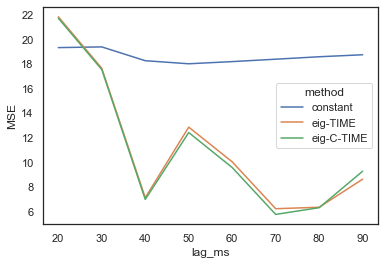

In [18]:
lp = sns.lineplot(x ='lag_ms', y ='MSE', hue='method', markers=True, data=results)
lp.set(xticks=lag_msS)